<a href="https://colab.research.google.com/github/averrise/averrise.github.io/blob/master/_posts/Fastai%26pytorch13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import torch


In [52]:
top_edge = torch.tensor([[-1, -1, -1],
                   [0,0,0],
                   [1, 1, 1]]).float()

<Axes: >

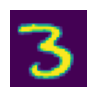

In [53]:
from fastai.tabular.all import *
from fastai.vision.all import *

path = untar_data(URLs.MNIST_SAMPLE)

im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3)

In [54]:
im3_t = tensor(im3)
im3_t[0:3, 0:3]*top_edge

tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [55]:
(im3_t[0:3, 0:3]*top_edge).sum()

tensor(0.)

In [56]:
df = pd.DataFrame(im3_t[:10, :20])
df.style.set_properties(**{'font-size' : '6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [57]:
(im3_t[4:7, 6:9] * top_edge).sum()

tensor(762.)

In [58]:
(im3_t[7:10, 17:20] * top_edge).sum()

tensor(-29.)

In [59]:
def apply_kernel(row, col, kernel):
  return (im3_t[row-1:row+2, col-1:col+2] * kernel).sum()

  apply_kernel(5,7,top_edge)

In [60]:
[[(i,j) for j in range(1,5)] for i in range(1,5)]

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

<Axes: >

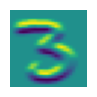

In [61]:
rng = range(1,27)
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])

show_image(top_edge3)

<Axes: >

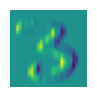

In [62]:
left_edge = tensor([[-1,1,0],
                    [-1,1,0],
                    [-1,1,0]]).float()

left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])

show_image(left_edge3)

In [63]:
diag1_edge = tensor([[0, -1, 1],
                     [-1, 1, 0],
                     [1, 0, 0]]).float()
diag2_edge = tensor([[1, -1, 0],
                     [0, 1, -1],
                     [0, 0, 1]]).float()

edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

In [64]:
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock),
                  get_items = get_image_files,
                  splitter = GrandparentSplitter(),
                  get_y = parent_label)

dls = mnist.dataloaders(path)
xb,yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

In [65]:
xb, yb = to_cpu(xb), to_cpu(yb)

In [66]:
edge_kernels = edge_kernels.unsqueeze(1)

batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

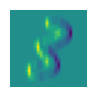

In [67]:
show_image(batch_features[0,0]);

In [68]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [69]:
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [70]:
broken_cnn = sequential(
    nn.Conv2d(1, 30, kernel_size = 3, padding = 1),
    nn.ReLU(),
    nn.Conv2d(30, 1, kernel_size = 3, padding = 1)
)

In [71]:
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

In [72]:
def conv(ni, nf, ks = 3, act=True):
  res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
  if act: res = nn.Sequential(res, nn.ReLU())
  return res

In [73]:
simple_cnn = sequential(
    conv(1, 4),
    conv(4, 8),
    conv(8, 16),
    conv(16, 32),
    conv(32, 2, act=False),
    Flatten(),
)

1개의 흑백 이미지를 받아 4개의 활성 맵을 생성

In [74]:
simple_cnn(xb).shape

torch.Size([64, 2])

In [75]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)

In [76]:
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

In [77]:
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.068877,0.048747,0.986261,00:13
1,0.026112,0.027535,0.990677,00:13


In [78]:
m = learn.model[1]
m

Sequential(
  (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

In [79]:
m[0].weight.shape

torch.Size([8, 4, 3, 3])

In [80]:
m[0].bias.shape

torch.Size([8])

In [81]:
im = image2tensor(Image.open('/content/drive/MyDrive/Colab Notebooks/feature-engneering/gom2.jpg'))
im.shape

torch.Size([3, 328, 520])

<Axes: >

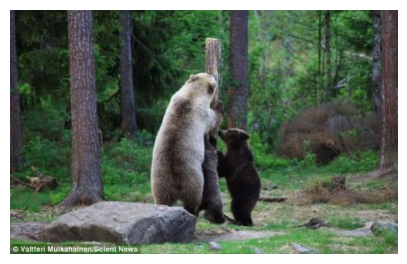

In [82]:
show_image(im)

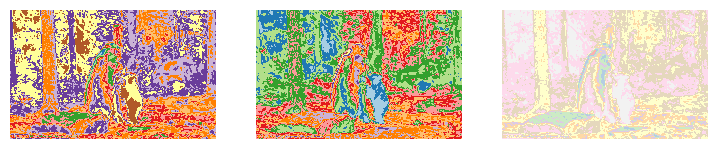

In [83]:
_,axs = subplots(1,3)
for bear,ax,color in zip(im, axs, ( 'Paired', 'Paired_r', 'Pastel1')):
  show_image(255-bear, ax=ax, cmap=color)

In [84]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/testing'),Path('/root/.fastai/data/mnist_png/training')]

In [85]:
def get_dls(bs = 64):
  return DataBlock(
      blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
              get_items=get_image_files,
              splitter = GrandparentSplitter('testing','training'),
              get_y = parent_label,
              batch_tfms=Normalize()
  ).dataloaders(path, bs=bs)

dls = get_dls()

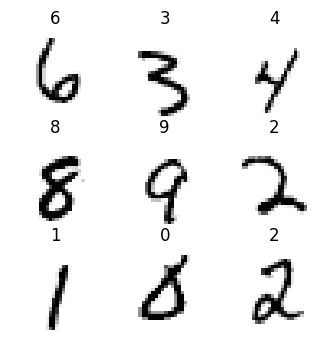

In [86]:
dls.show_batch(max_n = 9, figsize=(4,4))

In [87]:
def conv(ni, nf, ks= 3, act=True):
  res = nn.Conv2d(ni,nf,stride=2,kernel_size=ks,padding=ks//2)
  if act: res = nn.Sequential(res, nn.ReLU())
  return res

In [88]:
def simple_cnn():
  return sequential(
      conv(1,8, ks = 5),
      conv(8, 16),
      conv(16,32),
      conv(32,64),
      conv(64,10, act=False),
      Flatten(),)

In [89]:
from fastai.callback.hook import *

def fit(epochs = 1):
  learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                  metrics=accuracy, cbs=ActivationStats(with_hist=True))

  learn.fit(epochs, 0.06)
  return learn

learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.687191,0.579170,0.837567,01:07


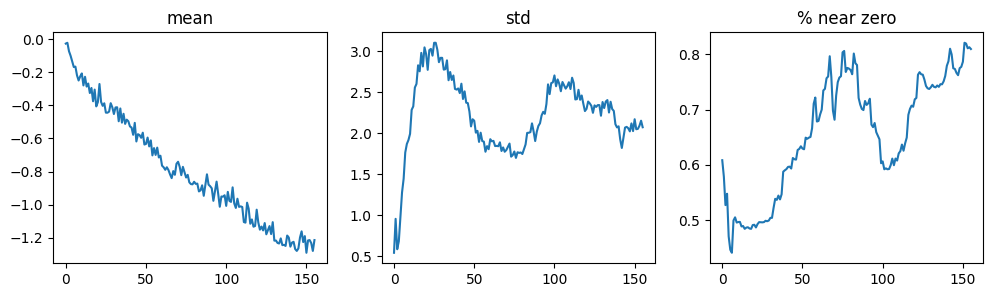

In [90]:
learn.activation_stats.plot_layer_stats(0)

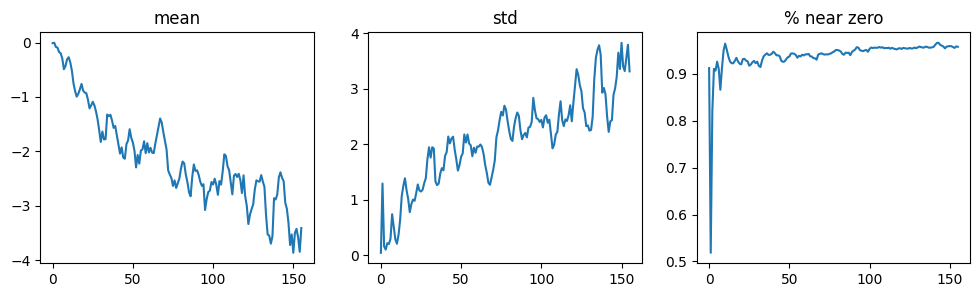

In [91]:
learn.activation_stats.plot_layer_stats(-2)

In [92]:
dls = get_dls(512)
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,2.462389,2.302116,0.112367,00:59


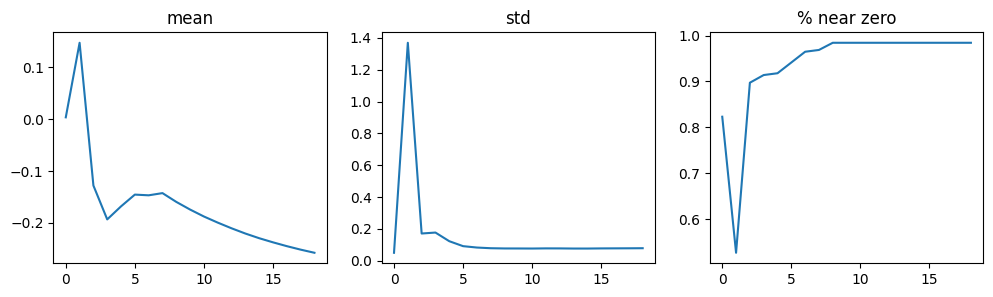

In [93]:
learn.activation_stats.plot_layer_stats(-2)

In [94]:
def fit1(epochs=1, lr=0.06):
  learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                  metrics = accuracy, cbs = ActivationStats(with_hist=True))
  learn.fit_one_cycle(epochs,lr)
  return learn
learn = fit1()

epoch,train_loss,valid_loss,accuracy,time
0,2.309456,2.301507,0.112367,01:03


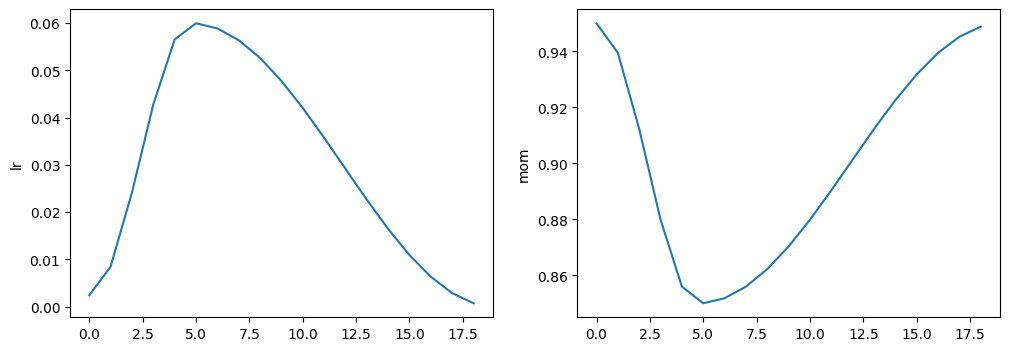

In [95]:
learn.recorder.plot_sched()

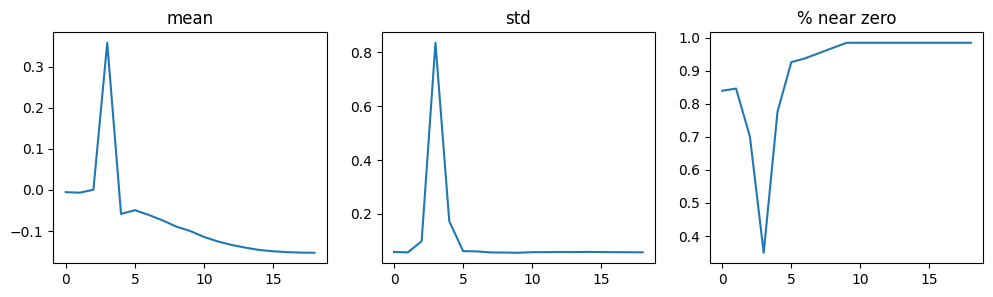

In [96]:
learn.activation_stats.plot_layer_stats(-2)

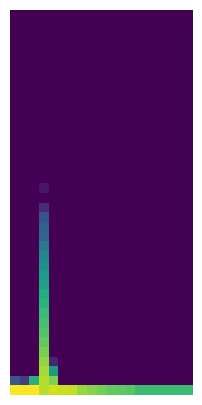

In [97]:
learn.activation_stats.color_dim(-2)

In [98]:
def conv(ni, nf, ks= 3, act=True):
  layers = [nn.Conv2d(ni,nf,stride=2,kernel_size=ks,padding=ks//2)]
  layers.append(nn.BatchNorm2d(nf))
  if act: layers.append(nn.ReLU())
  return nn.Sequential(*layers)

In [101]:
learn = fit1()

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.714264,0.245771,0.926067,01:12


In [102]:
learn = fit1(10, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.843028,0.428293,0.874683,01:03
1,0.480492,0.393626,0.887250,01:07
2,0.301599,0.250549,0.928200,01:03
3,0.206587,0.166091,0.951717,01:04
4,0.147849,0.118088,0.965433,01:04
5,0.108516,0.099702,0.969667,01:05
6,0.079348,0.097697,0.970333,01:06
7,0.057370,0.072575,0.978283,01:03
8,0.041173,0.069313,0.978933,01:04
9,0.030091,0.068948,0.979050,01:05


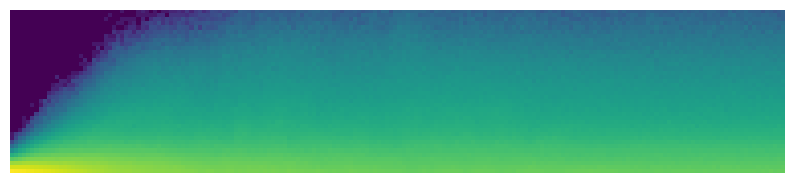

In [103]:
learn.activation_stats.color_dim(-4)